# Predicting Mackey Glass using Echo State Neural Network

### Importing Required Libraries

In [139]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import ESN
import pandas as pd

### Set seed for random weights generator

In [140]:
def set_seed(seed=None):
    """Making the seed (for random values) variable if None"""

    # Set the seed
    if seed is None:
        import time
        seed = int((time.time()*10**6) % 4294967295)
    try:
        np.random.seed(seed)
    except Exception as e:
        print( "!!! WARNING !!!: Seed was not set correctly.")
        print( "!!! Seed that we tried to use: "+str(seed))
        print( "!!! Error message: "+str(e))
        seed = None
    print( "Seed used for random values:", seed)
    return seed

In [141]:
## Set a particular seed for the random generator (for example seed = 42), or use a "random" one (seed = None)
# NB: reservoir performances should be averaged accross at least 30 random instances (with the same set of parameters)
seed = 42 #None #42

In [142]:
set_seed(seed) #random.seed(seed)

Seed used for random values: 42


42

In [143]:
initLen = 100
trainLen = initLen + 1400
testLen = 317

In [144]:
df =  pd.read_excel(r'C:\Users\INFO-DSK-02\Desktop\Lorentz Multi Dimension Prediction-Phase-2\Final_Version\3D_ReservoirComputing\Input\Mackey Glass Data\MCglass.xlsx', index = False)

In [145]:
df.shape

(12001, 2)

In [146]:
df['x'] = df['x'] + 1e-7

# EDA

In [147]:
import os
if not os.path.exists(r"C:\Users\INFO-DSK-02\Desktop\Lorentz Multi Dimension Prediction-Phase-2\Final_Version\3D_ReservoirComputing\images\Mackey Glass"):
    os.mkdir(r"C:\Users\INFO-DSK-02\Desktop\Lorentz Multi Dimension Prediction-Phase-2\Final_Version\3D_ReservoirComputing\images\Mackey Glass")

C:\Users\INFO-DSK-02\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  if __name__ == '__main__':


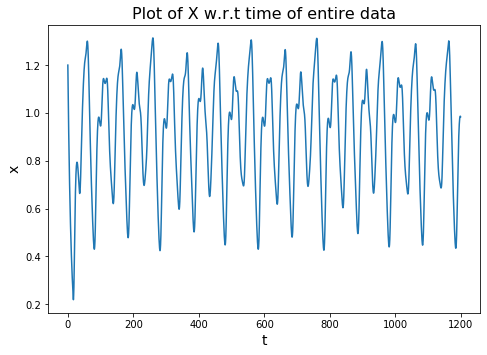

In [148]:
from matplotlib import rcParams
rcParams.update({'figure.autolayout': True})
fig = plt.figure()
ax=fig.add_axes([0,0,1,1])
ax.plot(df['t'],df['x'] )
plt.title('Plot of X w.r.t time of entire data',  fontsize=16)
plt.xlabel('t', fontsize = 14)
plt.ylabel('x', fontsize = 14)
plt.savefig(r"C:\Users\INFO-DSK-02\Desktop\Lorentz Multi Dimension Prediction-Phase-2\Final_Version\3D_ReservoirComputing\images\Mackey Glass\X_with_Time.png", bbox_inches = "tight")
plt.show()

### Split data for training and testing and creating teaches to train ESN on Input data

In [149]:
data_in = df[['x']]
data_T  =df['t']

In [150]:
data_in = np.array(data_in)
data_t = np.array(data_T)

In [151]:
train_in = np.array(data_in[0:trainLen])
train_out = np.array(data_in[0+10:trainLen+10])
test_in = np.array(data_in[trainLen:trainLen+testLen])
test_out = np.array(data_in[trainLen+10:trainLen+testLen+10])

In [152]:
test_in = test_in + 1e-7

In [153]:
trainLen+10

1510

In [154]:
trainLen+testLen+10

1827

In [155]:
train_in_t = np.array(data_T[0:trainLen])
train_out_t = np.array(data_T[0+10:trainLen])
test_in_t = np.array(data_T[trainLen:trainLen+testLen])
test_out_t = np.array(data_T[trainLen+10:trainLen+testLen+10])

In [156]:
len(test_in)

317

### <span style="color:blue">Modify Parameters to tune ESN for better fit</span> 

In [157]:
n_reservoir = 500 # number of recurrent units
leak_rate = 0.3 # leaking rate (=1/time_constant_of_neurons)
spectral_radius = 1.4 # Scaling of recurrent matrix
input_scaling = 1. # Scaling of input matrix
proba_non_zero_connec_W = 0.2 # Sparsity of recurrent matrix: Perceptage of non-zero connections in W matrix
proba_non_zero_connec_Win = 1. # Sparsity of input matrix
proba_non_zero_connec_Wfb = 1. # Sparsity of feedback matrix
regularization_coef =  0.01 #None # regularization coefficient, if None, pseudo-inverse is use instead of ridge regression

In [158]:
n_inputs = 1
input_bias = True # add a constant input to 1
n_outputs = 1

In [159]:
N = n_reservoir#100
dim_inp = n_inputs #26

### Generating weights for input and hidden layers 

In [160]:
### Generating random weight matrices with custom method
W = np.random.rand(N,N) - 0.5
if input_bias:
    Win = np.random.rand(N,dim_inp+1) - 0.5
else:
    Win = np.random.rand(N,dim_inp) - 0.5
Wfb = np.random.rand(N,n_outputs) - 0.5

In [161]:
## delete the fraction of connections given the sparsity (i.e. proba of non-zero connections):
mask = np.random.rand(N,N) # create a mask Uniform[0;1]
W[mask > proba_non_zero_connec_W] = 0 # set to zero some connections given by the mask
mask = np.random.rand(N,Win.shape[1])
Win[mask > proba_non_zero_connec_Win] = 0
# mask = np.random.rand(N,Wfb.shape[1])
# Wfb[mask > proba_non_zero_connec_Wfb] = 0

In [162]:
## SCALING of matrices
# scaling of input matrix
Win = Win * input_scaling
# scaling of recurrent matrix
# compute the spectral radius of these weights:
print( 'Computing spectral radius...')
original_spectral_radius = np.max(np.abs(np.linalg.eigvals(W)))
#TODO: check if this operation is quicker: max(abs(linalg.eig(W)[0])) #from scipy import linalg
print( "default spectral radius before scaling:", original_spectral_radius)
# rescale them to reach the requested spectral radius:
W = W * (spectral_radius / original_spectral_radius)
print( "spectral radius after scaling", np.max(np.abs(np.linalg.eigvals(W))))


Computing spectral radius...
default spectral radius before scaling: 2.9980673007522407
spectral radius after scaling 1.400000000000013


## <span style="color:Green">Input data dimensions</span>

In [163]:
print('Dimensions of Training data: ', train_in.shape[1])
print('Dimensions of Testing data: ', test_in.shape[1])

Dimensions of Training data:  1
Dimensions of Testing data:  1


### <span style="color:blue">Pass Parameters to ESN</span>

In [164]:
reservoir = ESN.ESN(lr=leak_rate, W=W, Win=Win, input_bias=input_bias, ridge=regularization_coef, Wfb=None, fbfunc=None)

## Input data to reservoir model

In [165]:
internal_trained = reservoir.train(inputs=[train_in], teachers=[train_out], wash_nr_time_step=initLen, verbose=False)
output_pred, internal_pred = reservoir.run(inputs=[test_in,], reset_state=False)
errorLen = len(test_out[:]) #testLen #2000

## Dimensions of the output data

In [166]:
print('Shape of Output data Dimensions: ', output_pred[0].shape[1])

Shape of Output data Dimensions:  1


### Create dataframe for predicted values and test values

In [167]:
import pandas as pd
df_pred = pd.DataFrame(output_pred[0])

In [168]:
df_pred.shape

(317, 1)

In [169]:
test_out = pd.DataFrame(test_out)

In [170]:
test_out.shape

(317, 1)

### <span style="color:blue">MSE for X</span>

In [171]:
## printing errors made on test set
# mse = sum( np.square( test_out[:] - output_pred[0] ) ) / errorLen
# print( 'MSE = ' + str( mse ))
mse_x = np.mean((test_out[0][:] - df_pred[0])**2) # Mean Squared Error: see https://en.wikipedia.org/wiki/Mean_squared_error
rmse_x = np.sqrt(mse_x) # Root Mean Squared Error: see https://en.wikipedia.org/wiki/Root-mean-square_deviation for more info
nmrse_mean_x = abs(rmse_x / np.mean(test_out[0][:])) # Normalised RMSE (based on mean)
nmrse_maxmin_x = rmse_x / abs(np.max(test_out[0][:]) - np.min(test_out[0][:])) # Normalised RMSE (based on max - min)

In [172]:
print("\n**********  MSE and RMSE for Predictions on X  **********")
print("Errors computed over %d time steps" % (errorLen))
print("\nMean Squared error (MSE) for x : \t\t%.4e " % (mse_x) )
print("Root Mean Squared error (RMSE) for x : \t\t%.4e\n " % rmse_x )
print("Normalized RMSE (based on mean) for x : \t%.4e " % (nmrse_mean_x) )
print("Normalized RMSE (based on max - min) for x : \t%.4e " % (nmrse_maxmin_x) )
print("*********************************************************\n")


**********  MSE and RMSE for Predictions on X  **********
Errors computed over 317 time steps

Mean Squared error (MSE) for x : 		9.4115e-06 
Root Mean Squared error (RMSE) for x : 		3.0678e-03
 
Normalized RMSE (based on mean) for x : 	3.0853e-03 
Normalized RMSE (based on max - min) for x : 	3.9754e-03 
*********************************************************



C:\Users\INFO-DSK-02\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  


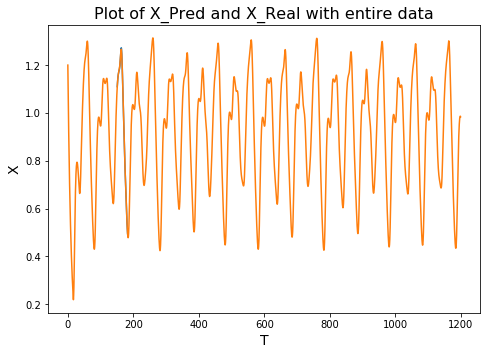

In [173]:
fig = plt.figure()
ax=fig.add_axes([0,0,1,1])
ax.plot(test_out_t,df_pred[0])
plt.title('Plot of X_Pred and X_Real with entire data',  fontsize=16)
plt.xlabel('T', fontsize = 14)
plt.ylabel('X', fontsize = 14)
ax.plot(df['t'],df['x'])
plt.savefig(r"C:\Users\INFO-DSK-02\Desktop\Lorentz Multi Dimension Prediction-Phase-2\Final_Version\3D_ReservoirComputing\images\Mackey Glass\X_Pred_X_Real_on Entire_data.png", bbox_inches = "tight")
plt.show()

C:\Users\INFO-DSK-02\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  


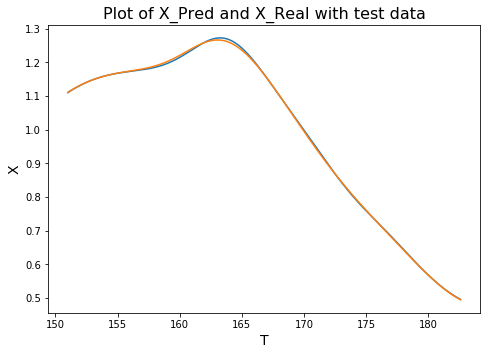

In [174]:
fig = plt.figure()
ax=fig.add_axes([0,0,1,1])
ax.plot(test_out_t,df_pred[0])
plt.title('Plot of X_Pred and X_Real with test data',  fontsize=16)
plt.xlabel('T', fontsize = 14)
plt.ylabel('X', fontsize = 14)
ax.plot(test_out_t,test_out[0])
plt.savefig(r"C:\Users\INFO-DSK-02\Desktop\Lorentz Multi Dimension Prediction-Phase-2\Final_Version\3D_ReservoirComputing\images\Mackey Glass\X_pred_vs_X_Real_with_time_on_Test_Data.png", bbox_inches = "tight")
plt.show()

# Plotting Local Error from predicted and actual values

In [175]:
df_local_error = pd.DataFrame()

In [176]:
df_local_error['X_Local_Error'] = test_out[0] - df_pred[0]

In [177]:
df_local_error.describe()

,X_Local_Error
count,317.000000
mean,-0.000372
std,0.003050
min,-0.007994
25%,-0.001931
50%,-0.000261
75%,0.001024
max,0.006037


C:\Users\INFO-DSK-02\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  import sys


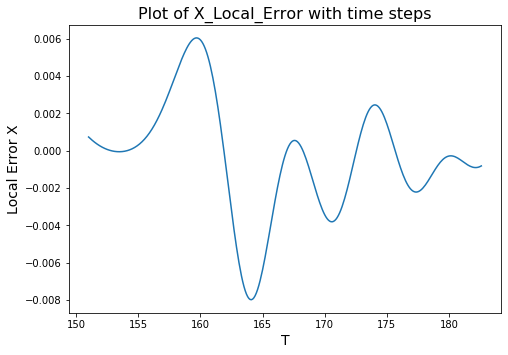

In [178]:
fig = plt.figure()
ax=fig.add_axes([0,0,1,1])
ax.plot(test_out_t,df_local_error['X_Local_Error'] )
plt.title('Plot of X_Local_Error with time steps',  fontsize=16)
plt.xlabel('T', fontsize = 14)
plt.ylabel('Local Error X', fontsize = 14)
plt.savefig(r"C:\Users\INFO-DSK-02\Desktop\Lorentz Multi Dimension Prediction-Phase-2\Final_Version\3D_ReservoirComputing\images\Mackey Glass\Local_Error_X.png", bbox_inches = "tight")
plt.show()

In [179]:
df_pred.columns= ['X_pred']

In [180]:
df_pred.head()

,X_pred
0,1.109942
1,1.112352
2,1.114706
3,1.117005
4,1.119249


In [181]:
test_out.columns = ['X_test']

In [182]:
df_out = pd.concat([df_pred, test_out], axis = 1)

In [183]:
df_out['Test_T'] = test_out_t

In [184]:
df_out.to_excel(r'C:\Users\INFO-DSK-02\Desktop\Lorentz Multi Dimension Prediction-Phase-2\Final_Version\3D_ReservoirComputing\Output\MC_Data\MG_Output_with_Noise.xlsx', index= False)